# Pythonの応用3 〜運動方程式の数値解〜

前回の演習では一階の連立微分方程式の数値シミュレーションを取り扱った.
今回はこれを応用して, 二階の微分方程式である運動方程式の解法を学び,
スポーツの一場面を力学的に解析してみよう.

## 物体の自由落下のシミュレーション

ここでは, 以下のような質点の自由落下をシミュレートする.

![自由落下のモデル](figs/freefall.png)

自由落下運動の模式図. 時刻 $t = 0$ に $x(0)=h$ で鉛直方向に速度 $u_0$ で
運動している物体（図の赤丸）の軌道をシミュレートする.
位置 $x$ および速度 $u$ の模式図は中・右図のようになる.

質点の質量を $m$ 、重力加速度を $g$ 、初期位置を $h$ 、初速を $u_0$ とする。
鉛直座標として $x$ をとると, 運動方程式は

$$
m\frac{d^2x}{dt^2}=-mg, \ \ \ x(0)=h, \ \ \ \frac{dx}{dt}(0)=u_0
$$

で与えられる.
その解は

$$
x(t)=h+u_0t-\frac{1}{2}gt^2.
$$

であるが, これをコンピュータを用いて近似的に求めてみよう.

上式を以下のように変形することで一階の連立微分方程式が得られる.

$$
\frac{dx}{dt}=u, \ \ \ x(0)=h, \\[3pt]
\frac{du}{dt}=-g, \ \ \ u(0)=u_0.
$$

これを前回学習したEuler法を用いて数値的に解けばよい.
プログラムの例を以下に示す.
計算した $x, u$ の時間変化をグラフにし,　厳密解と比較してみよ.

In [29]:
import numpy as np
%matplotlib inline
import matplotlib.pyplot as plt

def next_x(x, u, dt):
    """
    現在の x, u の値から、dt 後のxを求める関数。
    args:
    + x: 時刻 t での空間座標
    + u: 時刻 t での速度
    + dt: 線形近似する時間幅
    return:
     時刻t+dtでのxの値
    """
    return u*dt + x

def next_u_vacuum(x, u, dt, g):
    """
    現在の x, u の値から、dt 後のxを求める関数。空気抵抗は考慮しない。
    args:
    + x: 時刻 t での空間座標
    + u: 時刻 t での速度
    + dt: 線形近似する時間幅
    + g: 重力加速度の値
    return:
     時刻t+dt での u の値
    """
    return -g*dt + u

def solve_freefall_vacuum(x0, u0, dt, tmax):
    """
    t=0 に位置h、速度u0の物体の自由落下をシミュレートする関数。
    args:
    + x0: t=0での座標 [m]
    + u0: t=0での速度 [m/s]
    + dt: オイラー法を用いるための時間軸の刻み幅 [s]
    + tmax: 追跡を行う最大時間 [s]
    """
    # 計算結果を代入するリスト
    x_list = []
    u_list = []
    t_list = []
    
    g = 9.81 # 重力加速度 [m/s^2]
    
    # 初期値の代入
    x = x0
    u = u0
    t = 0.0
    
    while(t < tmax):
        x_list.append(x)
        u_list.append(u)
        t_list.append(t)
        
        # x, u, tの値の更新
        x = next_x(x,u,dt)
        u = next_u_vacuum(x,u,dt,g)
        t = t + dt
    return x_list, u_list, t_list

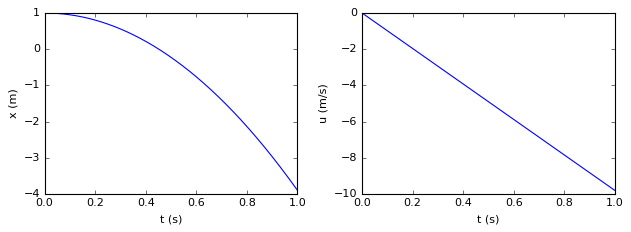

In [30]:
# 数値解
x_list, u_list, t_list = solve_freefall_vacuum(1.0, 0.0, 0.001, 1.0)

plt.figure(figsize=(8,3))
# t vs x のグラフ
plt.subplot(1,2,1)
plt.plot(t_list, x_list)
plt.xlabel('t (s)')
plt.ylabel('x (m)')
# t vs u のグラフ
plt.subplot(1,2,2)
plt.plot(t_list, u_list)
plt.xlabel('t (s)')
plt.ylabel('u (m/s)')
# 2つのグラフを綺麗に配置する。
plt.tight_layout()

## 空気抵抗下での自由落下のシミュレーション

上の例では空気抵抗の影響を無視したが、実際の系では多少なりとも空気抵抗が影響を及ぼす。
空気抵抗の大きさは物体の速度の大きさの二乗に比例し、その向きは物体の運動方向と逆向きとなる。
具体的には、空気抵抗力の大きさ $D$ は物体が球形の場合、

$$
D=\frac{1}{2}\rho |\mathbf{u}|^2 \pi a^2 C_D,
$$

と表せる。
なお、 $|\mathbf{u}|$ は速度ベクトル $\mathbf{u}$ の絶対値を表す。
ここで、 $\rho$ は空気の密度, $a$ は球の半径である。
また、抗力係数 $C_D$ はある条件のもと（注）では約0.44で一定であることが知られている。

解くべき微分方程式は、

$$
\frac{dx}{dt}=u, \ \ \ x(0)=h, \\[3pt]
\frac{du}{dt}=-g-\frac{D}{m}\frac{u}{|u|}, \ \ \ u(0)=u_0.
$$

となる.

空気抵抗の影響を含めた落下運動のシミュレーションを行うソースコードは以下のように書ける.
計算結果を, 空気抵抗のない場合と比較してみよ.

In [31]:
def next_u_air(x, u, dt, g, rho, a, m):
    """
    現在の x, u の値から、dt 後のxを求める関数。空気抵抗は考慮しない。
    args:
    + x: 時刻 t での空間座標 [m]
    + u: 時刻 t での速度 [m/s]
    + dt: 線形近似する時間幅 [s]
    + g: 重力加速度の値 [m/s^2]
    + rho: 空気の密度 [kg/m^3]
    + a: 物体の半径 [m]
    + m: 物体の質量 [kg]
    return:
     時刻t+dt での u の値
    """
    # 効力係数
    CD = 0.44 
    # 空気抵抗の大きさ
    D = 0.5 * rho * u**2.0 * np.pi * a**2.0 * CD
    return -g*dt -D/m * np.sign(u) + u


def solve_freefall_air(x0, u0, dt, tmax, a, m):
    """
    t=0 に位置h、速度u0の物体の自由落下をシミュレートする関数。
    args:
    + x0: t=0での座標 [m]
    + u0: t=0での速度 [m/s]
    + dt: オイラー法を用いるための時間軸の刻み幅 [s]
    + tmax: 追跡を行う最大時間 [s]
    + rho: 空気の密度 [kg/m^3]
    + a: 物体の半径 [m]
    + m: 物体の質量 [kg]
    """
    # 計算結果を代入するリスト
    x_list = []
    u_list = []
    t_list = []
    
    g = 9.81 # 重力加速度 [m/s^2]
    rho = 0.01 # kg/m^3
    
    # 初期値の代入
    x = x0
    u = u0
    t = 0.0
    
    while(t < tmax):
        x_list.append(x)
        u_list.append(u)
        t_list.append(t)
        
        # x, u, tの値の更新
        x = next_x(x,u,dt)
        u = next_u_air(x,u,dt,g,rho,a,m)
        t = t + dt
    return x_list, u_list, t_list

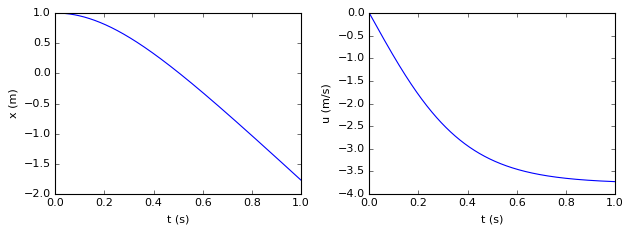

In [32]:
# 数値解
x_list, u_list, t_list = solve_freefall_air(1.0, 0.0, 0.001, 1.0, 0.1, 0.1)

plt.figure(figsize=(8,3))
# t vs x のグラフ
plt.subplot(1,2,1)
plt.plot(t_list, x_list)
plt.xlabel('t (s)')
plt.ylabel('x (m)')
# t vs u のグラフ
plt.subplot(1,2,2)
plt.plot(t_list, u_list)
plt.xlabel('t (s)')
plt.ylabel('u (m/s)')
# 2つのグラフを綺麗に配置する。
plt.tight_layout()

### 課題
上記の関数を用いて、以下を数値的に調べよ。結果をグラフに描画せよ。

+ 大きいリンゴと小さいリンゴはどちらが早く落ちるか? リンゴの密度は等しいものとする.
+ 同じ大きさのリンゴと鉄球はどちらが早く落ちるか?

## 空気抵抗下での野球ボール軌道のシミュレーション

ここでは、以下の図に示すような野球ボールの軌道をシミュレートする。
ここで野球ボールは、以下のように時刻 $t=0$ で 原点($x=0, z=0$)から,
斜め方向に $x, z$ 方向の速度成分 $u_x, u_z$ で打ち出される.

![斜方投射の模式図](figs/shahou.png)

野球ボール軌道の模式図. 時刻$t = 0$ に $x(0)=0, z(0)=0$ で
斜め方向に速度$u_x(0), u_z(0)$で打ち出された球状の物体（図の赤丸）が,
重力および空気抵抗の影響を受けて運動する様子をシミュレートする.
位置$z$および$z$方向速度$u_z$の模式図は中・右図のようになる.

この場合, 空気抵抗の$x, z$方向の成分はそれぞれ

$$ 
\begin{aligned}
D_x &= -D u_x / |\mathbf{u}| \\[3pt]
D_z &= -D u_z / |\mathbf{u}| \\[3pt]
\end{aligned}
$$

と表される.

運動方程式は, 速度に関する微分方程式

$$
\begin{aligned}
\frac{\mathrm{d}u_x}{\mathrm{d}t} &= \frac{D_x}{m},\\
\frac{\mathrm{d}u_z}{\mathrm{d}t} &= \frac{D_z}{m} - g,\\
\end{aligned}
$$

と, 位置に関する微分方程式

$$
\begin{aligned}
\frac{\mathrm{d}x}{\mathrm{d}t} &= u_x,\\
\frac{\mathrm{d}z}{\mathrm{d}t} &= u_z,\\
\end{aligned}
$$

と表される.

### 課題

大谷翔平は野球ボールを最大球速 165km/h で投げることができる。
彼は地面に対しどの方向(角度 $\theta$)に対してもこの初速で野球ボールを投げ出すことができ、
ボールの回転は考慮しないものとする。
また、彼の身長は193cmで腕の長さは85cmとする。

これら仮定のもとで、以下の状況をシミュレーションせよ。

+ 空気抵抗がない場合($C_D=0$), 適当な角度$\theta$に対するシミュレーションをおこない, 解析解と比較せよ.
ボールのリリース点の高さは適当に設定すること.
+ 空気抵抗がある場合のシミュレーションをおこない, 空気抵抗がない場合と比較せよ.


各物理量の具体的な値については, 以下の表を参考にするとよい.

|   パラメータ |      値      |    備考   |
|:----------:|:------------:|:---------:|
|   $m$ [kg] | 0.145 | 野球ボール |
|  半径$a$ [m]|0.036 | 野球ボール |
|   重力加速度$g$ [m/s $^2$ ] | 9.80665 | - |
|空気の密度 $\rho$[kg/m $^3$ ] | 1.261 | 280Kの場合 |
|                     　      | 1.176 | 300Kの場合 |
|空気の動粘性係数 $\nu \mathrm([m^2/s])$| 1.395 $\times 10^{-5}$ | 280Kの場合 |
|                                     | 1.579 $\times 10^{-5}$ | 300Kの場合 |
|抗力係数$C_D$[-] | 0.44 | $5 \times 10^2 < Re < 1 \times 10^5$のとき |
|Reynolds数$Re$[-] | - | $2aU/\nu$ |

### 課題

空気抵抗のもとでの放物運動が関係するスポーツシーンを何でもよいので一つ取り上げ, 適当な問題設定に対するシミュレーションを実施せよ.

［例］

+ 野球ボールを最も遠くまで飛ばすためには,
大谷翔平は地面に対しどの角度で野球ボールを投げる必要があるか.
+ 大谷翔平が投げたボールがストライクになるためには, どのような角度で投げればよいか.
初速, ピッチャーとキャッチャーの距離やストライクゾーンの広さは適当に設定せよ.
+ サッカーのフリーキックで壁を越えてゴールに入れるにはどのような初速、角度で蹴ればよいか。
ゴールまでの距離や壁の高さは自由に設定せよ。

注：
<font color="Gray">
Reynolds数$Re=2aU/\nu$ ($\nu$は空気の動粘性係数, $U$は系の代表速度)と呼ばれる無次元数が
$5 \times 10^2 < Re < 1 \times 10^5$のときにこの近似が有効である.
</font>
